# Make figures of WOMBATlite improvement relative to previous WOMBAT 

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import xarray as xr
import scipy as sci
import h5py as h5

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# regridding package
import xesmf as xe

# statistics package
import skill_metrics as sm


# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("xarray version =", xr.__version__)
print("scipy version =", sci.__version__)
print("h5py version =", h5.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("xesmf version =", xe.__version__)


wrkdir = "/g/data/es60/pjb581/liteexps"
os.chdir(wrkdir)



python version = 3.10.
numpy version = 1.26.4
pandas version = 2.2.1
xarray version = 2023.6.0
scipy version = 1.12.0
h5py version = 3.9.0
matplotlib version = 3.8.0
cmocean version = v3.0.3
cartopy version = 0.22.0
xesmf version = 0.8.5


## load the previous and new WOMBATlite datasets

In [2]:
optimexp = 21
numyears=100

fs_new = "./lite2output_optim_1-20_%iyears/outputexp_%iyear_%i.nc"%(numyears,numyears,optimexp)
fs_old = "../biov3/outputexp_%iyear_WOMBATold.nc"%(numyears)

var = ['surno3', 'surfer', 'intnpp', 'fgco2', 'phylim', 'pocsink']

old = {}
new = {}

old[var[0]] = xr.open_dataset(fs_old)['SURNO3'].squeeze()
old[var[1]] = xr.open_dataset(fs_old)['SURFER'].squeeze()
old[var[2]] = xr.open_dataset(fs_old)['INTNPP'].squeeze()
old[var[3]] = xr.open_dataset(fs_old)['FGCO2'].squeeze()
old[var[4]] = old[var[0]]*0+2.0

new[var[0]] = xr.open_dataset(fs_new)['SURNO3'].squeeze()
new[var[1]] = xr.open_dataset(fs_new)['SURFER'].squeeze()
new[var[2]] = xr.open_dataset(fs_new)['INTNPP'].squeeze()
new[var[3]] = xr.open_dataset(fs_new)['FGCO2'].squeeze()
new[var[4]] = xr.open_dataset(fs_new)['PHY_LIM'].squeeze()
new['surchl'] = xr.open_dataset(fs_new)['SURCHL'].squeeze()
new['chmaxz'] = xr.open_dataset(fs_new)['CHMAXZ'].squeeze()

if numyears==10:
    fs_new_det = "./lite2optim%i/oceanbgc-3d-det-1-monthly-mean-y_1909.nc"%(optimexp)
    fs_new_wdet = "./lite2optim%i/oceanbgc-3d-wdet-1-monthly-mean-y_1909.nc"%(optimexp)
    fs_old_det = "../biov3/oceanbgc-3d-det-1-monthly-mean-y_1909.nc"

if numyears==100:
    fs_new_det = "./lite2optim%i/oceanbgc-3d-det-1-monthly-mean-y_1999.nc"%(optimexp)
    fs_new_wdet = "./lite2optim%i/oceanbgc-3d-wdet-1-monthly-mean-y_1999.nc"%(optimexp)
    fs_old_det = "../biov3/oceanbgc-3d-det-1-monthly-mean-y_1999.nc"

old[var[5]] = (xr.open_dataset(fs_old_det)['det'].squeeze()).isel(st_ocean=13) * 24.0 * 12.0 * 106/16.0
new[var[5]] = (xr.open_dataset(fs_new_wdet)['wdet'].squeeze() * xr.open_dataset(fs_new_det)['det'].squeeze()).isel(st_ocean=13) * 86400.0 * 12

fs = './lite2output_optim_1-20_%iyears/outputexp_%iyear_%i_pocsink.nc'%(numyears,numyears,optimexp)
oldpoc = xr.open_dataset(fs)['POCSINK_XYT'].squeeze()
fs = "../biov3/outputexp_%iyear_WOMBATold_pocsink.nc"%(numyears)
newpoc = xr.open_dataset(fs)['POCSINK_XYT'].squeeze()


### get the river flux and subtrack from the air-sea fluxes
rivdic = xr.open_dataset("/g/data/es60/pjb581/wombat_files/mom_1deg_new/rivdic.nc")['rivdic'].squeeze()
rivdoc = xr.open_dataset("/g/data/es60/pjb581/wombat_files/mom_1deg_new/rivdoc.nc")['rivdoc'].squeeze()
rivcar = rivdic+rivdoc
# resample to monthly resolution from the 5-daily resolution
rivcar = rivcar.resample(time='M').mean()
# rename coordinate and dimensions to fit with the FGCO2 data
rivcar = rivcar.rename({"time":"TIME", "grid_y_T":"YT_OCEAN", "grid_x_T":"XT_OCEAN"})
rivcar = rivcar.assign_coords(TIME=new[var[3]].coords['TIME'], YT_OCEAN=new[var[3]].coords['YT_OCEAN'])

# take the river fluxes off the air-sea fluxes
new[var[3]] = new[var[3]] - rivcar*365*86400*1e-3




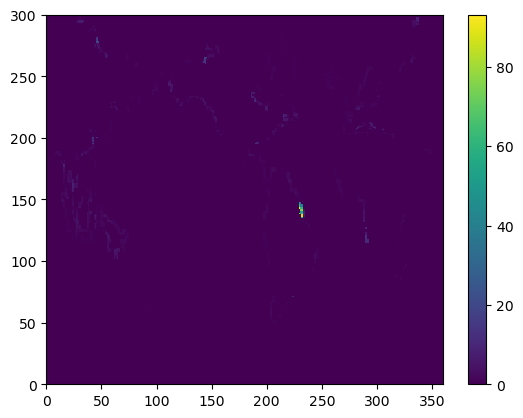

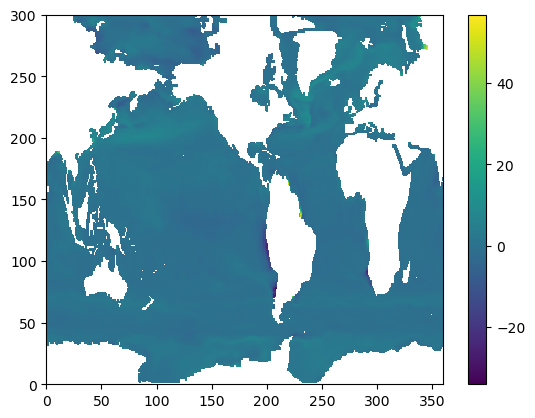

In [3]:
plt.figure()
plt.pcolormesh(rivcar.isel(TIME=0)*365*86400*1e-3)
plt.colorbar()

plt.figure()
plt.pcolormesh(new[var[3]].isel(TIME=0))
plt.colorbar()


### remove the depth component of the POCsink dataset to make direct comparisons with the data

In [4]:
print("we use the pocflux_Mouw2016.txt data created earlier")
pocflux_new = pd.read_excel("../../observations/pocflux_Mouw2016.xlsx")

oldpoc_flux = np.zeros((len(pocflux_new)))*np.nan
newpoc_flux = np.zeros((len(pocflux_new)))*np.nan
print(np.shape(oldpoc_flux))

zeta = xr.open_dataset('ocean_vgrid.nc')['zeta'].squeeze()
dep_mod = zeta.isel(nzv=slice(1,101,2))
top_mod = zeta.isel(nzv=slice(0,100,2))
bot_mod = zeta.isel(nzv=slice(2,101,2))

print("to subsample the model output at the right depth levels")
for ii in np.arange(0,len(oldpoc[0,:])):
    tmppoc = oldpoc[:,ii]
    tmpdep = pocflux_new['Dep'].iloc[ii]
    tmpind = (top_mod < tmpdep) & (bot_mod > tmpdep)
    if np.any(tmpind):
        oldpoc_flux[ii] = tmppoc.rename({"ST_OCEAN":"nzv"})[tmpind]
    else:
        oldpoc_flux[ii] = np.nan

for ii in np.arange(0,len(newpoc[0,:])):
    tmppoc = newpoc[:,ii]
    tmpdep = pocflux_new['Dep'].iloc[ii]
    tmpind = (top_mod < tmpdep) & (bot_mod > tmpdep)
    if np.any(tmpind):
        newpoc_flux[ii] = tmppoc.rename({"ST_OCEAN":"nzv"})[tmpind]
    else:
        newpoc_flux[ii] = np.nan



we use the pocflux_Mouw2016.txt data created earlier
(2503,)
to subsample the model output at the right depth levels


## get observations

In [5]:
os.chdir(wrkdir)

# WOA 2023 Nitrate
nan_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].squeeze()
n01_woa = xr.open_dataset("../../observations/woa23_all_n01_01.nc", decode_times=False)['n_an'].squeeze()
n02_woa = xr.open_dataset("../../observations/woa23_all_n02_01.nc", decode_times=False)['n_an'].squeeze()
n03_woa = xr.open_dataset("../../observations/woa23_all_n03_01.nc", decode_times=False)['n_an'].squeeze()
n04_woa = xr.open_dataset("../../observations/woa23_all_n04_01.nc", decode_times=False)['n_an'].squeeze()
n05_woa = xr.open_dataset("../../observations/woa23_all_n05_01.nc", decode_times=False)['n_an'].squeeze()
n06_woa = xr.open_dataset("../../observations/woa23_all_n06_01.nc", decode_times=False)['n_an'].squeeze()
n07_woa = xr.open_dataset("../../observations/woa23_all_n07_01.nc", decode_times=False)['n_an'].squeeze()
n08_woa = xr.open_dataset("../../observations/woa23_all_n08_01.nc", decode_times=False)['n_an'].squeeze()
n09_woa = xr.open_dataset("../../observations/woa23_all_n09_01.nc", decode_times=False)['n_an'].squeeze()
n10_woa = xr.open_dataset("../../observations/woa23_all_n10_01.nc", decode_times=False)['n_an'].squeeze()
n11_woa = xr.open_dataset("../../observations/woa23_all_n11_01.nc", decode_times=False)['n_an'].squeeze()
n12_woa = xr.open_dataset("../../observations/woa23_all_n12_01.nc", decode_times=False)['n_an'].squeeze()

lon_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['lon']
lat_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['lat']
dep_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['depth']

# Dissolved Iron (Huang, Y.,Tagliabue, A., & Cassar, N. (2022). Data-driven modeling of dissolved iron in the global ocean. Frontier in Marine Science))
dfe_Huang = xr.open_dataset("../../observations/Monthly_dFe.nc")['dFe_RF']
dfe_Huang = dfe_Huang.isel(Month=slice(0,12)).rename({"Month":"month", "Depth":"depth"})
lon_Huang = dfe_Huang.coords['Longitude']
lat_Huang = dfe_Huang.coords['Latitude']

no3_woa = xr.concat([n01_woa, n02_woa, n03_woa, n04_woa, n05_woa, n06_woa, n07_woa, n08_woa, n09_woa, n10_woa, n11_woa, n12_woa], dim="month")
nan_woa = xr.concat([nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa], dim="month")
no3_woa = no3_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
nan_woa = nan_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
no3_woa = xr.concat([no3_woa, nan_woa.isel(depth=slice(43,102))], dim='depth')

del n01_woa, n02_woa, n03_woa, n04_woa, n05_woa, n06_woa, n07_woa, n08_woa, n09_woa, n10_woa, n11_woa, n12_woa, nan_woa


### Chlorophyll and POC
chl01_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_01_P20210906.nc", decode_times=True)['chl']
chl02_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_02_P20210906.nc", decode_times=True)['chl']
chl03_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_03_P20210906.nc", decode_times=True)['chl']
chl04_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_04_P20210906.nc", decode_times=True)['chl']
chl05_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_05_P20210906.nc", decode_times=True)['chl']
chl06_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_06_P20210906.nc", decode_times=True)['chl']
chl07_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_07_P20210906.nc", decode_times=True)['chl']
chl08_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_08_P20210906.nc", decode_times=True)['chl']
chl09_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_09_P20210906.nc", decode_times=True)['chl']
chl10_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_10_P20210906.nc", decode_times=True)['chl']
chl11_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_11_P20210906.nc", decode_times=True)['chl']
chl12_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_12_P20210906.nc", decode_times=True)['chl']

chl_cop = xr.concat([chl01_cop, chl02_cop, chl03_cop, chl04_cop, chl05_cop, chl06_cop, chl07_cop, chl08_cop, chl09_cop, chl10_cop, chl11_cop, chl12_cop], dim="time")
chl_cop = chl_cop.rename({"time":"month"})

del chl01_cop, chl02_cop, chl03_cop, chl04_cop, chl05_cop, chl06_cop, chl07_cop, chl08_cop, chl09_cop, chl10_cop, chl11_cop, chl12_cop

### grid coordinate information and depth thicknesses
lon_cop = chl_cop.coords['longitude']
lat_cop = chl_cop.coords['latitude']
dep_cop = chl_cop.coords['depth']

### get surface values and vertically integrated values
surchl_cop = chl_cop.isel(depth=0)

### get the depth maximums of Chl and POC
chmaxz_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_pomchlmax.nc", decode_times=True)['CHMAXZ'].rename({"LONGITUDE":"longitude", "LATITUDE":"latitude", "TIME":"time"})


### Copernicus CO2 fluxes
co201_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850115T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co202_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850215T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co203_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850315T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co204_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850415T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co205_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850515T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co206_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850615T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co207_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850715T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co208_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850815T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co209_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850915T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co210_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19851015T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co211_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19851115T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co212_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19851215T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co2_cop = xr.concat([co201_cop, co202_cop, co203_cop, co204_cop, co205_cop, co206_cop, co207_cop, co208_cop, co209_cop, co210_cop, co211_cop, co212_cop], dim="time")
co2_cop = co2_cop.rename({"time":"month"})
del co201_cop, co202_cop, co203_cop, co204_cop, co205_cop, co206_cop, co207_cop, co208_cop, co209_cop, co210_cop, co211_cop, co212_cop
co2_cop
lon_co2 = co2_cop.coords['longitude']
lat_co2 = co2_cop.coords['latitude']


### Net Primary Production
with h5.File('../../observations/MODIS_Chl.mat', 'r') as file:
    modis_lon = np.array(file['Lon'])
    modis_lat = np.array(file['Lat'])
    modis_tim = np.array(file['time_steps'])
with h5.File('../../observations/MODIS_Carbon_NPP.mat', 'r') as file:
    modis_npp = np.array(file['NPP'])
print("Got NPP")


### nutrient limitation dataset
limitations = pd.read_excel("../../observations/Browning_Moore_Bioassay_Dataset_v1.0.xlsx", skiprows=0, usecols=(2,3,24,25,26))
limitations.columns = ['Lon', 'Lat', 'Primary', 'Secondary', 'Tertiary']
limitations = limitations.drop(limitations.index[0])
### print out the unique kinds of primary limitations
print(limitations['Primary'].unique())
### drop Manganese and NaNs
limitations = limitations[limitations['Primary'] != 'Mn']
limitations = limitations.dropna(subset=['Primary'])
# N = 1
# P = 2
# Fe = 3
# Si = 4
limitations.loc[limitations['Primary'] == 'N', 'Primary'] = 2.0
limitations.loc[limitations['Primary'] == 'N_P', 'Primary'] = 1.5
limitations.loc[limitations['Primary'] == 'P', 'Primary'] = 1.0
limitations.loc[limitations['Primary'] == 'Fe', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'Fe_Mn', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'Fe_Co', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'Fe_Zn_sep', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'N_Fe', 'Primary'] = 2.5
limitations.loc[limitations['Primary'] == 'N_Fe_sep', 'Primary'] = 2.5
### print out the unique kinds of primary limitations
print(limitations['Primary'].unique())


### POC sinking rate
pocflux = pd.read_table("../../observations/Mouw_2016_particle_fluxes/GO_flux.tab", skiprows=87, usecols=(1,3,4,8,9,11,15,16,17,18,40))
pocflux.columns = ['Location ID', 'Latitude', 'Longitude', 'Depth (m)', 'Datetime deployed', 'Duration (days)', 'C flux [mg/m**2/day]', 'C flux std dev', 'POC flux [mg/m**2/day]', 'POC flux std dev', 'Reference']
print("Number of unique locations with POC flux data =", len(pocflux['Location ID'].unique()))
# First, find the mean month of sampling by averaging the start and end month 
pocflux['Month_start'] = pocflux['Datetime deployed'].str[5:7].astype(float)
pocflux['Month_end'] = pocflux['Month_start'] + pocflux['Duration (days)'] / 30.0
pocflux['Month'] = (pocflux['Month_start'] + pocflux['Month_end'] ) *0.5
print(pocflux['Month_start'].min(), pocflux['Month_start'].max())
print(pocflux['Month_end'].min(), pocflux['Month_end'].max())
print(pocflux['Month'].min(), pocflux['Month'].max())
# if the average month carries over into the next year, remove 12 to account for this
pocflux.loc[pocflux['Month'] >= 12.5, 'Month'] += -12
print(pocflux['Month'].min(), pocflux['Month'].max())
# Bin the months into 13 different numerical (integer) categories representing all months (1-12) and an annual average (0)
pocflux['Month'] = pd.cut(pocflux['Month'], bins = [0.49, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 1e5]).cat.codes + 1
print(pocflux['Month'].min(), pocflux['Month'].max())
print(pocflux.loc[pocflux['Month']==0,['Datetime deployed', 'Duration (days)']])
pocflux.loc[pocflux['Month']==13, 'Month'] = 0
print(pocflux['Month'].min(), pocflux['Month'].max())
# Now find the average measured POC fluxes and the locations and months of sampling. We can therefore have multiple months of sampling at the same location.
pocflux_ave = pocflux.groupby(['Month', 'Location ID'])['POC flux [mg/m**2/day]'].mean()
pocflux_std = pocflux.groupby(['Month', 'Location ID'])['POC flux [mg/m**2/day]'].std()
pocflux_lon = pocflux.groupby(['Month', 'Location ID'])['Longitude'].mean()
pocflux_lat = pocflux.groupby(['Month', 'Location ID'])['Latitude'].mean()
pocflux_dep = pocflux.groupby(['Month', 'Location ID'])['Depth (m)'].mean()
pocflux_mon = pocflux.groupby(['Month', 'Location ID'])['Month'].mean()
pocflux_std_measured = pocflux.groupby(['Month', 'Location ID'])['POC flux std dev'].mean()



/jobfs/130474645.gadi-pbs/ipykernel_1060326/3455502987.py:30: UserWarning: rename 'time' to 'month' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  no3_woa = no3_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})


Got NPP
['N' 'Fe' 'N_Fe' nan 'N_P' 'Mn' 'Fe_Mn' 'Fe_Zn_sep' 'Fe_Co' 'N_Fe_sep']
[2.0 3.0 2.5 1.5]
Number of unique locations with POC flux data = 674
1.0 12.0
1.0 150.76666666666668
1.0 79.88333333333334
0.5 67.88333333333334
0 13
     Datetime deployed  Duration (days)
7676               NaN            6.185
7687               NaN           10.994
7690               NaN           10.869
7736               NaN            3.771
7774               NaN           22.562
7827               NaN            2.653
7828               NaN            2.653
7829               NaN            2.653
0 12


## regrid the observations

In [6]:
### choose regular grid for regridding to
ds_out = xe.util.grid_global(1,1)
lon_reg = ds_out.coords['lon']
lat_reg = ds_out.coords['lat']

### regrid the WOA data
lon_woa, lat_woa = np.meshgrid(lon_woa, lat_woa)
ds_in = xr.Dataset(
    {'no3_woa': ( ('month', 'y', 'x'), no3_woa.isel(depth=0).values),
     },
    coords={"lon": (['y','x'], lon_woa),
            "lat": (['y','x'], lat_woa),
            "month": (['month'], no3_woa.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
no3_woa_reg = regridder(ds_in['no3_woa'])


### regrid the Huang data
lon_Huang, lat_Huang = np.meshgrid(lon_Huang, lat_Huang)
ds_in = xr.Dataset(
    {'dfe_Huang': ( ('month', 'y', 'x'), dfe_Huang.isel(depth=0).values),
     },
    coords={"lon": (['y','x'], lon_Huang),
            "lat": (['y','x'], lat_Huang),
            "month": (['month'], dfe_Huang.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
dfe_Huang_reg = regridder(ds_in['dfe_Huang'])


### regrid the Copernicus chlorophyll/POC dataset
lon_cop, lat_cop = np.meshgrid(lon_cop, lat_cop)
ds_in = xr.Dataset(
    {'surchl_cop': ( ('month', 'y', 'x'), surchl_cop.values),
     'chmaxz_cop': ( ('month', 'y', 'x'), chmaxz_cop.values),
     },
    coords={"lon": (['y','x'], lon_cop),
            "lat": (['y','x'], lat_cop),
            "month": (['month'], surchl_cop.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
surchl_cop_reg = regridder(ds_in['surchl_cop'])
chmaxz_cop_reg = regridder(ds_in['chmaxz_cop'])
### make all zero values equal to NaNs
chmaxz_cop_reg = chmaxz_cop_reg.where(chmaxz_cop_reg != 0.0)
### delete the large datasets from memory
del chl_cop, surchl_cop, chmaxz_cop


### regrid the CO2 fluxes
lon_co2, lat_co2 = np.meshgrid(lon_co2, lat_co2)
ds_in = xr.Dataset(
    {'fgco2_cop': ( ('month', 'y', 'x'), co2_cop.values),
     },
    coords={"lon": (['y','x'], lon_co2),
            "lat": (['y','x'], lat_co2),
            "month": (['month'], co2_cop.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
fgco2_cop_reg = regridder(ds_in['fgco2_cop'])
### delete the large datasets from memory
del co2_cop


### regrid the NPP data
ds_in = xr.Dataset(
    {'modis_npp': ( ('day', 'y', 'x'), modis_npp.transpose((2,1,0))),
     },
    coords={"lon": (['y','x'], modis_lon.transpose((1,0))),
            "lat": (['y','x'], modis_lat.transpose((1,0))),
            "day": (['day'], modis_tim[:,0]),
            }
    )
print("Regridding")
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
modis_npp_reg = regridder(ds_in['modis_npp'])
### delete the large datasets from memory
del modis_npp



/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Regridding


/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


## put the NPP data on a monthly time resolution from an 8-day resolution

In [7]:
from datetime import datetime, timedelta

# 1. create new datetime array with dates of MODIS climatology
days_of_year = modis_tim[:,0]
year = 2005
start_date = datetime(year, 1, 1)
mons = [(start_date + timedelta(days=int(day)-1)).month for day in days_of_year]
days = [(start_date + timedelta(days=int(day)-1)).day for day in days_of_year]
year = np.ones(len(days))*2005
dates = pd.DataFrame({'year':year.astype(int), 'month':mons, 'day':days})
daycoordinate = pd.to_datetime(dates)

# 2. apply new dates to modis xarray coordinate
modis_npp_reg = modis_npp_reg.assign_coords({'day':daycoordinate.values})

# 3. set the monthly center points
month_points = pd.date_range(start=datetime(2005, 1, 1), periods=12, freq='MS') + pd.offsets.Day(14)

# 4. interpolate the data to the monthly center points and rename time coordinate
modis_npp_reg = modis_npp_reg.interp(day=month_points, method='linear').rename({'day':'month'})



## put the limitations and POC sinking rate datasets onto the model grid

In [8]:
print("binning primary limiting nutrient")
limits_reg = np.zeros((180,360))*np.nan
for xi,xx in enumerate(lon_reg[0,:].values):
    for yi,yy in enumerate(lat_reg[:,0].values):
        limxs = (limitations['Lon'] >= xx-0.5) & (limitations['Lon'] < xx+0.5)
        limys = (limitations['Lat'] >= yy-0.5) & (limitations['Lat'] < yy+0.5)
        if np.any(limxs*limys):
            tmp = limitations[limxs*limys]
            limits_reg[yi,xi] = tmp['Primary'].mean()
        else:
            continue
limits_reg = xr.DataArray(limits_reg, dims=('lat', 'lon'))
print("Number of limiting nutrient measurements before binning?", limitations['Primary'].count())
print("Number of limiting nutrient measurements after binning?", limits_reg.count().values)


print("binning particle flux dataset")
# get the vertical grid information since this dataset is in 3D (4D in time)
vgrid  = xr.open_dataset("../wombat_files/ocean_vgrid.nc").rename({"zeta":"z", "nzv":"z"})
dep = vgrid['z'][1:-1:2]
dep_b = vgrid['z'][0::2]
dep_thick = dep_b[1::]-dep_b[0:-1]

cc = 0
pocflux_reg = np.zeros((13,50,180,360))*np.nan
for xi,xx in enumerate(lon_reg.values[0,:]):
    limxs = (pocflux_lon >= xx-0.5) & (pocflux_lon < xx+0.5)
    if np.any(limxs) == False:
        continue
    else:
        tmp1_ave = pocflux_ave[limxs]
        tmp1_lat = pocflux_lat[limxs]
        tmp1_dep = pocflux_dep[limxs]
        tmp1_mon = pocflux_mon[limxs]
    
    for yi,yy in enumerate(lat_reg.values[:,0]):
        limys = (tmp1_lat >= yy-0.5) & (tmp1_lat < yy+0.5)
        if np.any(limys) == False:
            continue
        else:
            tmp2_ave = tmp1_ave[limys]
            tmp2_dep = tmp1_dep[limys]
            tmp2_mon = tmp1_mon[limys]
        
        for zi,zz in enumerate(dep.values):
            limzs = (tmp2_dep >= dep_b.values[zi]) & (tmp2_dep < dep_b.values[zi+1])
            if np.any(limzs) == False:
                continue
            else:
                tmp3_ave = tmp2_ave[limzs]
                tmp3_mon = tmp2_mon[limzs]
                
            for mm in np.arange(0,13,1):
                limms = tmp3_mon.astype(int) == mm
                if np.any(limms) == False:
                    continue
                else:
                    tmp4_ave = tmp3_ave[limms]
                    pocflux_reg[mm,zi,yi,xi] = tmp4_ave.mean()
                    #print("Found a POC flux measurement at", mm,xi,yi,zi, "with %i values"%(tmp4_ave.count()))
                    cc += 1

pocflux_reg = xr.DataArray(pocflux_reg, dims=('month', 'depth', 'lat', 'lon'))
print("Number of POC flux measurements before binning?", pocflux_ave.count())
print("Number of POC flux measurements after binning?", pocflux_reg.count().values)


pocflux_new = pd.DataFrame({'Lon':pocflux_lon.values,
                            'Lat':pocflux_lat.values,
                            'Dep':pocflux_dep.values,
                            'Mon':pocflux_mon.values,
                            'flux_mean':pocflux_ave.values,
                            'flux_std':pocflux_std.values,
                            })



binning primary limiting nutrient
Number of limiting nutrient measurements before binning? 942
Number of limiting nutrient measurements after binning? 137
binning particle flux dataset
Number of POC flux measurements before binning? 2399
Number of POC flux measurements after binning? 1986


## Regrid the model output

In [9]:
lon_mod = xr.open_dataset('./lite2output_optim_1-20_10years/outputexp_10year_1.nc').coords['XT_OCEAN']
lat_mod = xr.open_dataset('./lite2output_optim_1-20_10years/outputexp_10year_1.nc').coords['YT_OCEAN']
lon_mod, lat_mod = np.meshgrid(lon_mod, lat_mod)

ds_in_old = xr.Dataset(
    {var[0]: ( ('month', 'y', 'x'), old[var[0]].values),
     var[1]: ( ('month', 'y', 'x'), old[var[1]].values),
     var[2]: ( ('month', 'y', 'x'), old[var[2]].values),
     var[3]: ( ('month', 'y', 'x'), old[var[3]].values),
     var[4]: ( ('y', 'x'), old[var[4]].mean(dim='TIME').values),
     var[5]: ( ('month', 'y', 'x'), old[var[5]].values),
     },
    coords={"lon": (['y','x'], lon_mod),
            "lat": (['y','x'], lat_mod),
            "month": (['month'], no3_woa.coords['month'].values),
            }
    )


ds_in_new = xr.Dataset(
    {var[0]: ( ('month', 'y', 'x'), new[var[0]].values),
     var[1]: ( ('month', 'y', 'x'), new[var[1]].values),
     var[2]: ( ('month', 'y', 'x'), new[var[2]].values),
     var[3]: ( ('month', 'y', 'x'), new[var[3]].values),
     var[4]: ( ('y', 'x'), new[var[4]].mean(dim='TIME').values),
     'surchl': ( ('month', 'y', 'x'), new['surchl'].values),
     'chmaxz': ( ('month', 'y', 'x'), new['chmaxz'].values),
     var[5]: ( ('month', 'y', 'x'), new[var[5]].values),
    },
    coords={"lon": (['y','x'], lon_mod),
            "lat": (['y','x'], lat_mod),
            "month": (['month'], no3_woa.coords['month'].values),
            }
    )

print("Regridding model output")
regridder = xe.Regridder(ds_in_old, ds_out, 'nearest_s2d')
ds_old_reg = {}
for vv in var:
    ds_old_reg[vv] = regridder(ds_in_old[vv])
regridder = xe.Regridder(ds_in_new, ds_out, 'nearest_s2d')
ds_new_reg = {}
for vv in var:
    ds_new_reg[vv] = regridder(ds_in_new[vv])
ds_new_reg['surchl'] = regridder(ds_in_new['surchl'])
ds_new_reg['chmaxz'] = regridder(ds_in_new['chmaxz'])



Regridding model output


## visualise the changes between the new and old

In [10]:
print("making latitude and longitude coordinates 1 dimensional")

ds_old = xr.Dataset(
    {var[0]: ( ('month', 'y', 'x'), ds_old_reg[var[0]].values),
     var[1]: ( ('month', 'y', 'x'), ds_old_reg[var[1]].values),
     var[2]: ( ('month', 'y', 'x'), ds_old_reg[var[2]].values),
     var[3]: ( ('month', 'y', 'x'), ds_old_reg[var[3]].values),
     var[4]: ( ('y', 'x'), ds_old_reg[var[4]].values),
     var[5]: ( ('month', 'y', 'x'), ds_old_reg[var[5]].values),
    },
    coords={"lon": (['x'], lon_reg.isel(y=0).values),
            "lat": (['y'], lat_reg.isel(x=0).values),
            "month": (['month'], no3_woa.coords['month'].values),
           }
)

ds_new = xr.Dataset(
    {var[0]: ( ('month', 'y', 'x'), ds_new_reg[var[0]].values),
     var[1]: ( ('month', 'y', 'x'), ds_new_reg[var[1]].values),
     var[2]: ( ('month', 'y', 'x'), ds_new_reg[var[2]].values),
     var[3]: ( ('month', 'y', 'x'), ds_new_reg[var[3]].values),
     var[4]: ( ('y', 'x'), ds_new_reg[var[4]].values),
     'surchl': ( ('month', 'y', 'x'), ds_new_reg['surchl'].values),
     'chmaxz': ( ('month', 'y', 'x'), ds_new_reg['chmaxz'].values),
     var[5]: ( ('month', 'y', 'x'), ds_new_reg[var[5]].values),
    },
    coords={"lon": (['x'], lon_reg.isel(y=0).values),
            "lat": (['y'], lat_reg.isel(x=0).values),
            "month": (['month'], no3_woa.coords['month'].values),
           }
)

print("adding cyclic point")
from cartopy.util import add_cyclic_point

no3_old_cyclic, lon_cyclic = add_cyclic_point(ds_old[var[0]].mean(dim='month'), coord=ds_old[var[0]].coords['lon'])
dfe_old_cyclic, lon_cyclic = add_cyclic_point(ds_old[var[1]].mean(dim='month'), coord=ds_old[var[0]].coords['lon'])
npp_old_cyclic, lon_cyclic = add_cyclic_point(ds_old[var[2]].mean(dim='month'), coord=ds_old[var[0]].coords['lon'])
co2_old_cyclic, lon_cyclic = add_cyclic_point(ds_old[var[3]].mean(dim='month'), coord=ds_old[var[0]].coords['lon'])
lim_old_cyclic, lon_cyclic = add_cyclic_point(ds_old[var[4]], coord=ds_old[var[0]].coords['lon'])
poc_old_cyclic, lon_cyclic = add_cyclic_point(ds_old[var[5]].mean(dim='month'), coord=ds_old[var[0]].coords['lon'])

no3_new_cyclic, lon_cyclic = add_cyclic_point(ds_new[var[0]].mean(dim='month'), coord=ds_new[var[0]].coords['lon'])
dfe_new_cyclic, lon_cyclic = add_cyclic_point(ds_new[var[1]].mean(dim='month'), coord=ds_new[var[0]].coords['lon'])
chl_new_cyclic, lon_cyclic = add_cyclic_point(ds_new['surchl'].mean(dim='month'), coord=ds_new[var[0]].coords['lon'])
chz_new_cyclic, lon_cyclic = add_cyclic_point(ds_new['chmaxz'].mean(dim='month'), coord=ds_new[var[0]].coords['lon'])
npp_new_cyclic, lon_cyclic = add_cyclic_point(ds_new[var[2]].mean(dim='month'), coord=ds_new[var[0]].coords['lon'])
co2_new_cyclic, lon_cyclic = add_cyclic_point(ds_new[var[3]].mean(dim='month'), coord=ds_new[var[0]].coords['lon'])
lim_new_cyclic, lon_cyclic = add_cyclic_point(ds_new[var[4]], coord=ds_new[var[0]].coords['lon'])
poc_new_cyclic, lon_cyclic = add_cyclic_point(ds_new[var[5]].mean(dim='month'), coord=ds_new[var[0]].coords['lon'])



making latitude and longitude coordinates 1 dimensional
adding cyclic point


## make observations cyclic

In [11]:
from cartopy.util import add_cyclic_point

### assign single dimension to longitudes and latitudes
lons = lon_reg.isel(y=0).values
lats = lat_reg.isel(x=0).values
no3_woa_reg2 = xr.DataArray(
    no3_woa_reg.values,
    dims=['month', 'lat', 'lon'],
    coords={"month": no3_woa_reg.coords['month'], "lat":lats, "lon":lons}
)
dfe_Huang_reg2 = xr.DataArray(
    dfe_Huang_reg.values,
    dims=['month', 'lat', 'lon'],
    coords={"month": dfe_Huang_reg.coords['month'], "lat":lats, "lon":lons}
)
surchl_cop_reg2 = xr.DataArray(
    surchl_cop_reg.values,
    dims=['month', 'lat', 'lon'],
    coords={"month": surchl_cop_reg.coords['month'], "lat":lats, "lon":lons}
)
chmaxz_cop_reg2 = xr.DataArray(
    chmaxz_cop_reg.values,
    dims=['month', 'lat', 'lon'],
    coords={"month": chmaxz_cop_reg.coords['month'], "lat":lats, "lon":lons}
)
modis_npp_reg2 = xr.DataArray(
    modis_npp_reg.values,
    dims=['month', 'lat', 'lon'],
    coords={"month": modis_npp_reg.coords['month'], "lat":lats, "lon":lons}
)
fgco2_cop_reg2 = xr.DataArray(
    fgco2_cop_reg.values,
    dims=['month', 'lat', 'lon'],
    coords={"month": fgco2_cop_reg.coords['month'], "lat":lats, "lon":lons}
)

'''
no3_old_diff = ds_old[var[0]] - no3_woa_reg2
dfe_old_diff = ds_old[var[1]] - dfe_Huang_reg2
npp_old_diff = ds_old[var[2]] - modis_npp_reg2
co2_old_diff = ds_old[var[3]] - fgco2_cop_reg2

no3_new_diff = ds_new[var[0]] - no3_woa_reg2
dfe_new_diff = ds_new[var[1]] - dfe_Huang_reg2
chl_new_diff = ds_new['surchl'] - surchl_cop_reg2
chz_new_diff = ds_new['chmaxz'] - chmaxz_cop_reg2
npp_new_diff = ds_new[var[2]] - modis_npp_reg2
co2_new_diff = ds_new[var[3]] - fgco2_cop_reg2
'''
no3_obs_cyclic, lon_cyclic = add_cyclic_point(no3_woa_reg2.mean(dim='month'), coord=no3_woa_reg2.coords['lon'])
dfe_obs_cyclic, lon_dfecyc = add_cyclic_point(dfe_Huang_reg2.mean(dim='month'), coord=dfe_Huang_reg2.coords['lon'])
chl_obs_cyclic, lon_cyclic = add_cyclic_point(surchl_cop_reg2.mean(dim='month'), coord=surchl_cop_reg2.coords['lon'])
chz_obs_cyclic, lon_cyclic = add_cyclic_point(chmaxz_cop_reg2.mean(dim='month'), coord=chmaxz_cop_reg2.coords['lon'])
npp_obs_cyclic, lon_cyclic = add_cyclic_point(modis_npp_reg2.mean(dim='month'), coord=modis_npp_reg2.coords['lon'])
co2_obs_cyclic, lon_cyclic = add_cyclic_point(fgco2_cop_reg2.mean(dim='month'), coord=fgco2_cop_reg2.coords['lon'])
'''
no3_olddiff_cyclic, lon_cyclic = add_cyclic_point(no3_old_diff.mean(dim='month'), coord=no3_woa_reg2.coords['lon'])
dfe_oldiff_cyclic, lon_dfecyc = add_cyclic_point(dfe_old_diff.mean(dim='month'), coord=dfe_Huang_reg2.coords['lon'])
npp_oldiff_cyclic, lon_cyclic = add_cyclic_point(npp_old_diff.mean(dim='month'), coord=modis_npp_reg2.coords['lon'])
co2_oldiff_cyclic, lon_cyclic = add_cyclic_point(co2_old_diff.mean(dim='month'), coord=fgco2_cop_reg2.coords['lon'])

no3_newdiff_cyclic, lon_cyclic = add_cyclic_point(no3_new_diff.mean(dim='month'), coord=no3_woa_reg2.coords['lon'])
dfe_newdiff_cyclic, lon_dfecyc = add_cyclic_point(dfe_new_diff.mean(dim='month'), coord=dfe_Huang_reg2.coords['lon'])
chl_newdiff_cyclic, lon_cyclic = add_cyclic_point(chl_new_diff.mean(dim='month'), coord=surchl_cop_reg2.coords['lon'])
chz_newdiff_cyclic, lon_cyclic = add_cyclic_point(chz_new_diff.mean(dim='month'), coord=chmaxz_cop_reg2.coords['lon'])
npp_newdiff_cyclic, lon_cyclic = add_cyclic_point(npp_new_diff.mean(dim='month'), coord=modis_npp_reg2.coords['lon'])
co2_newdiff_cyclic, lon_cyclic = add_cyclic_point(co2_new_diff.mean(dim='month'), coord=fgco2_cop_reg2.coords['lon'])
'''


"\nno3_olddiff_cyclic, lon_cyclic = add_cyclic_point(no3_old_diff.mean(dim='month'), coord=no3_woa_reg2.coords['lon'])\ndfe_oldiff_cyclic, lon_dfecyc = add_cyclic_point(dfe_old_diff.mean(dim='month'), coord=dfe_Huang_reg2.coords['lon'])\nnpp_oldiff_cyclic, lon_cyclic = add_cyclic_point(npp_old_diff.mean(dim='month'), coord=modis_npp_reg2.coords['lon'])\nco2_oldiff_cyclic, lon_cyclic = add_cyclic_point(co2_old_diff.mean(dim='month'), coord=fgco2_cop_reg2.coords['lon'])\n\nno3_newdiff_cyclic, lon_cyclic = add_cyclic_point(no3_new_diff.mean(dim='month'), coord=no3_woa_reg2.coords['lon'])\ndfe_newdiff_cyclic, lon_dfecyc = add_cyclic_point(dfe_new_diff.mean(dim='month'), coord=dfe_Huang_reg2.coords['lon'])\nchl_newdiff_cyclic, lon_cyclic = add_cyclic_point(chl_new_diff.mean(dim='month'), coord=surchl_cop_reg2.coords['lon'])\nchz_newdiff_cyclic, lon_cyclic = add_cyclic_point(chz_new_diff.mean(dim='month'), coord=chmaxz_cop_reg2.coords['lon'])\nnpp_newdiff_cyclic, lon_cyclic = add_cyclic_poin

### difference plots rather than side-by-side

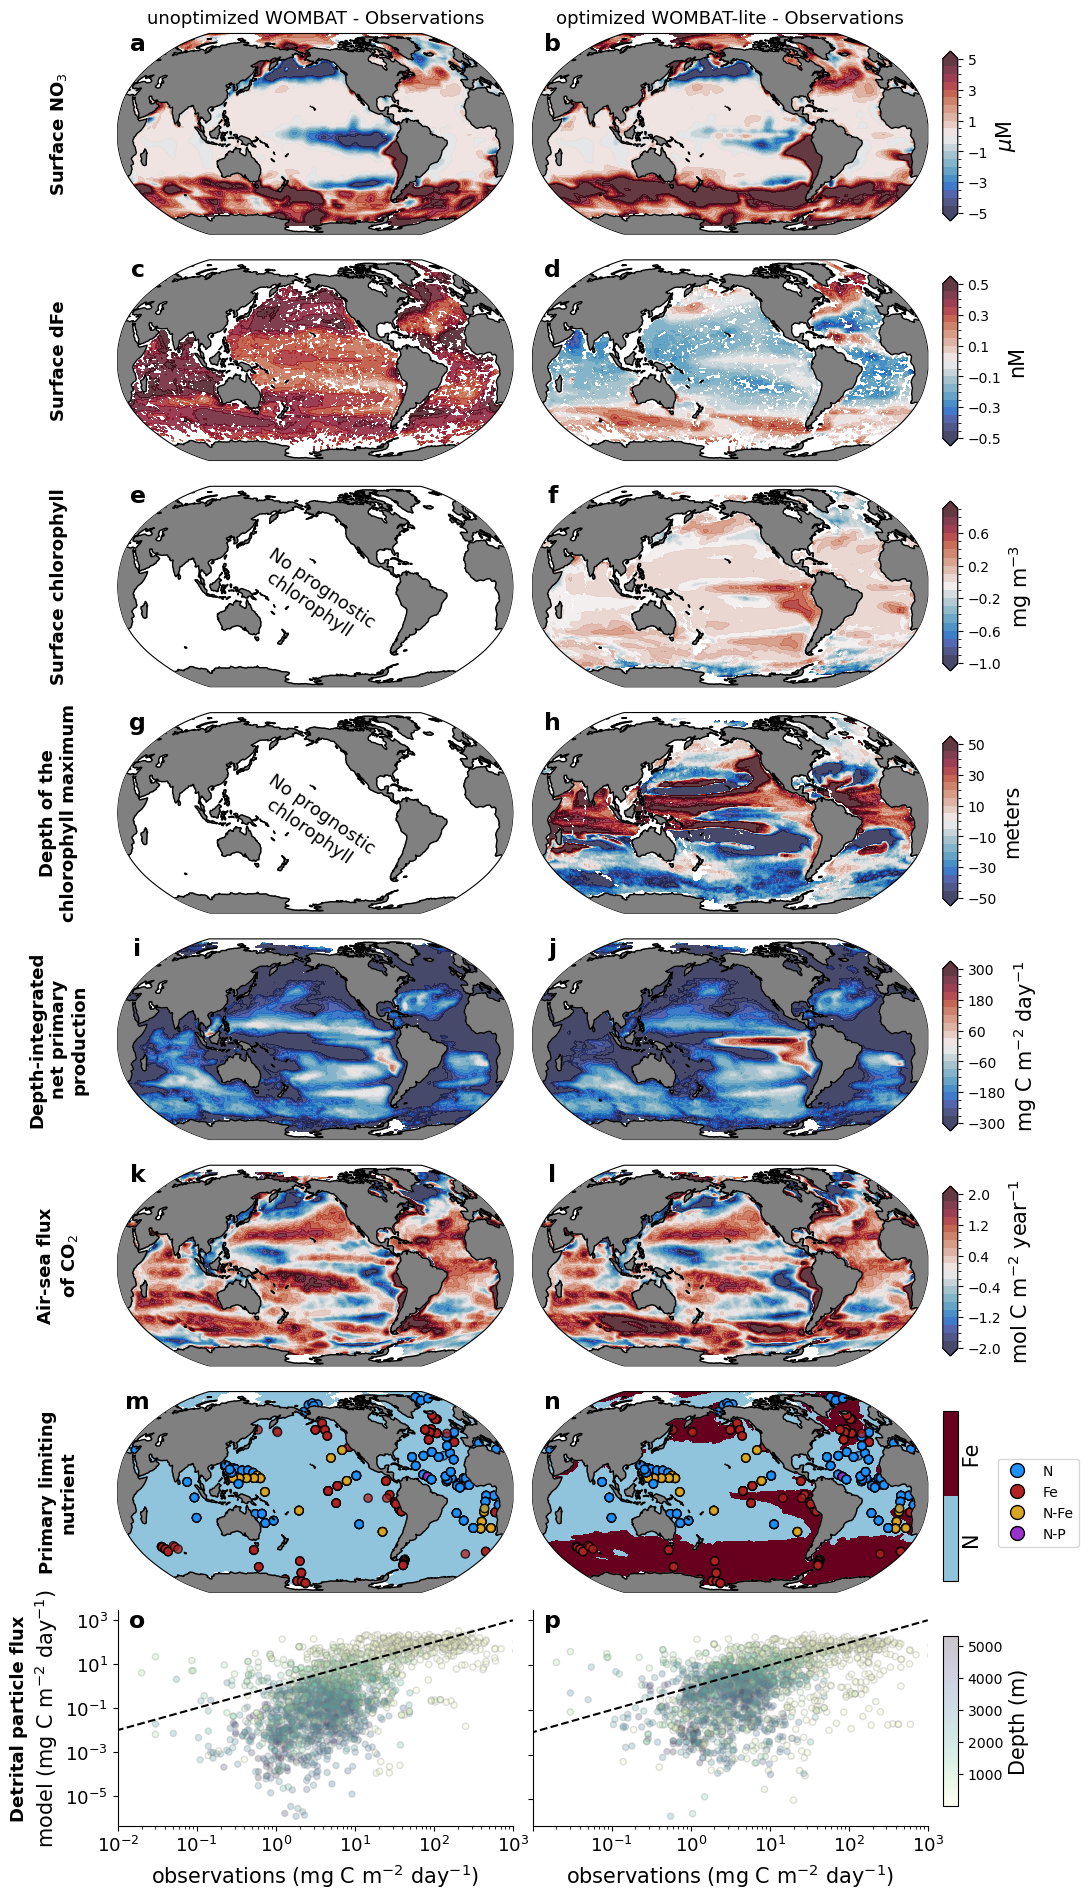

In [12]:
fslab = 15
fstic = 13

import matplotlib.lines as mlines
from cartopy.util import add_cyclic_point

proj = ccrs.Robinson(central_longitude=205)

colmap1 = lighten(cmo.balance, 0.8)
colmap2 = lighten(cmo.balance, 0.8)
colmap3 = lighten(cmo.balance, 0.8)
colmap4 = lighten(cmo.balance, 0.8)
colmap5 = lighten(cmo.balance, 0.8)
colmap6 = lighten(cmo.balance, 0.8)
colmap7 = {2.0:'dodgerblue', 3.0:'firebrick', 2.5:'goldenrod', 1.5:'darkorchid'}
colmap8 = lighten(cmo.amp, 0.8)

# surface NO3
levs1 = np.arange(-5,5.1,0.5)
norm1 = mcolors.BoundaryNorm(levs1, ncolors=256)

# Surface dFe
levs2 = np.arange(-0.5,0.51,0.05)
norm2 = mcolors.BoundaryNorm(levs2, ncolors=256)

# Surface chlorophyll
levs3 = np.arange(-1,1,0.1)
norm3 = mcolors.BoundaryNorm(levs3, ncolors=256)

# Depth of max Chl
levs4 = np.arange(-50,51,5)
norm4 = mcolors.BoundaryNorm(levs4, ncolors=256)

# Depth-integrated NPP (MODIS-based CbPM algorithm)
levs5 = np.arange(-300,301,30)
norm5 = mcolors.BoundaryNorm(levs5, ncolors=256)

# Downward flux of CO2
levs6 = np.arange(-2,2.1,0.2)
norm6 = mcolors.BoundaryNorm(levs6, ncolors=256)

# Primary limiting nutrient
colors7 = [colmap7[lim] for lim in limitations['Primary']] 

# Downward flux of POC through ocean interior
levs8 = np.concatenate((np.arange(0,10,1), np.arange(10,100,10), np.arange(100,501,50)))
norm8 = mcolors.BoundaryNorm(levs8, ncolors=256)


fig = plt.figure(figsize=(10,20), facecolor='w')
gs = GridSpec(8, 2)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[1,0], projection=proj)
ax4 = plt.subplot(gs[1,1], projection=proj)
ax5 = plt.subplot(gs[2,0], projection=proj)
ax6 = plt.subplot(gs[2,1], projection=proj)
ax7 = plt.subplot(gs[3,0], projection=proj)
ax8 = plt.subplot(gs[3,1], projection=proj)
ax9 = plt.subplot(gs[4,0], projection=proj)
ax10 = plt.subplot(gs[4,1], projection=proj)
ax11 = plt.subplot(gs[5,0], projection=proj)
ax12 = plt.subplot(gs[5,1], projection=proj)
ax13 = plt.subplot(gs[6,0], projection=proj)
ax14 = plt.subplot(gs[6,1], projection=proj)
ax15 = plt.subplot(gs[7,0])
ax16 = plt.subplot(gs[7,1])

ax15.spines[['top','right']].set_visible(False)
ax16.spines[['top','right']].set_visible(False)
ax15.tick_params(labelsize=fstic)
ax16.tick_params(labelsize=fstic, labelleft=False)

p1 = ax1.contourf(lon_cyclic, lat_reg.isel(x=0), no3_old_cyclic - no3_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='both')
p2 = ax2.contourf(lon_cyclic, lat_reg.isel(x=0), no3_new_cyclic - no3_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='both')

p3 = ax3.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_old_cyclic - dfe_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='both')
p4 = ax4.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_new_cyclic - dfe_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='both')

#p5 = ax5.contourf(lon_cyclic, lat_reg.isel(x=0), chl_old_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')
p6 = ax6.contourf(lon_cyclic, lat_reg.isel(x=0), chl_new_cyclic - chl_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='both')

#p7 = ax7.contourf(lon_cyclic, lat_reg.isel(x=0), chz_old_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='max')
p8 = ax8.contourf(lon_cyclic, lat_reg.isel(x=0), chz_new_cyclic - chz_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='both')

p9 = ax9.contourf(lon_cyclic, lat_reg.isel(x=0), npp_old_cyclic - npp_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')
p10 = ax10.contourf(lon_cyclic, lat_reg.isel(x=0), npp_new_cyclic - npp_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')

p11 = ax11.contourf(lon_cyclic, lat_reg.isel(x=0), (-1)*co2_old_cyclic - (-1)*co2_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap6, norm=norm6, levels=levs6, extend='both')
p12 = ax12.contourf(lon_cyclic, lat_reg.isel(x=0), (-1)*co2_new_cyclic - (-1)*co2_obs_cyclic+1e-2, transform=ccrs.PlateCarree(), cmap=colmap6, norm=norm6, levels=levs6, extend='both')

p13 = ax13.contourf(lon_cyclic, lat_reg.isel(x=0), lim_old_cyclic, transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.array([1.5,2.1,3.5]), extend='neither', vmax=2.5)
p14 = ax14.contourf(lon_cyclic, lat_reg.isel(x=0), lim_new_cyclic, transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.array([1.5,2.1,3.5]), extend='neither', vmax=2.5)
ax13.scatter(limitations['Lon'], limitations['Lat'], c=colors7, transform=ccrs.PlateCarree(), alpha=0.75, edgecolor='k')
ax14.scatter(limitations['Lon'], limitations['Lat'], c=colors7, transform=ccrs.PlateCarree(), alpha=0.75, edgecolor='k')
points = [mlines.Line2D([], [], color=colmap7[2.0], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='N'),
          mlines.Line2D([], [], color=colmap7[3.0], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='Fe'),
          mlines.Line2D([], [], color=colmap7[2.5], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='N-Fe'),
          mlines.Line2D([], [], color=colmap7[1.5], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='N-P')]
ax14.legend(handles=points, bbox_to_anchor=(1.4,0.7))

p15 = ax15.scatter(pocflux_new['flux_mean'], oldpoc_flux, c=pocflux_new['Dep'], marker='o', cmap=cmo.deep, alpha=0.25, s=20, edgecolor='grey' )
p16 = ax16.scatter(pocflux_new['flux_mean'], newpoc_flux, c=pocflux_new['Dep'], marker='o', cmap=cmo.deep, alpha=0.25, s=20, edgecolor='grey' )

ax15.plot((1e-5,1e3),(1e-5,1e3), 'k--')
ax16.plot((1e-5,1e3),(1e-5,1e3), 'k--')

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax2.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax3.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax3.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax4.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax4.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax9.add_feature(cfeature.LAND, color='grey', zorder=3)
ax9.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax12.add_feature(cfeature.LAND, color='grey', zorder=3)
ax12.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax13.add_feature(cfeature.LAND, color='grey', zorder=3)
ax13.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax14.add_feature(cfeature.LAND, color='grey', zorder=3)
ax14.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)


xx = -0.15; yy = 0.5
plt.text(xx,yy, 'Surface NO$_3$', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax1.transAxes)
plt.text(xx,yy, 'Surface dFe', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax3.transAxes)
plt.text(xx,yy, 'Surface chlorophyll', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax5.transAxes)
plt.text(xx,yy, 'Depth of the\nchlorophyll maximum', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax7.transAxes)
plt.text(xx,yy, 'Depth-integrated\nnet primary\nproduction', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax9.transAxes)
plt.text(xx,yy, 'Air-sea flux\nof CO$_2$', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax11.transAxes)
plt.text(xx,yy, 'Primary limiting\nnutrient', ha='center', va='center', fontweight='bold', rotation=90, fontsize=fstic, transform=ax13.transAxes)
plt.text(xx-0.1,yy, 'Detrital particle flux', ha='center', va='center', fontweight='bold', rotation=90, fontsize=fstic, transform=ax15.transAxes)

plt.text(0.5, 1.075, 'unoptimized WOMBAT - Observations', va='center', ha='center', fontsize=fstic, transform=ax1.transAxes)
plt.text(0.5, 1.075, 'optimized WOMBAT-lite - Observations', va='center', ha='center', fontsize=fstic, transform=ax2.transAxes)

plt.subplots_adjust(left=0.075, bottom=0.05, top=0.95, right=0.885, hspace=0.05, wspace=0.05)


cbax1 = fig.add_axes([0.9, 0.8525, 0.015, 0.085])
cbax2 = fig.add_axes([0.9, 0.7400, 0.015, 0.085])
cbax3 = fig.add_axes([0.9, 0.6275, 0.015, 0.085])
cbax4 = fig.add_axes([0.9, 0.5100, 0.015, 0.085])
cbax5 = fig.add_axes([0.9, 0.3975, 0.015, 0.085])
cbax6 = fig.add_axes([0.9, 0.2850, 0.015, 0.085])
cbax7 = fig.add_axes([0.9, 0.1725, 0.015, 0.085])
cbax8 = fig.add_axes([0.9, 0.0600, 0.015, 0.085])

cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::4])
cbar2 = plt.colorbar(p3, cax=cbax2, orientation='vertical', ticks=levs2[::4])
cbar3 = plt.colorbar(p6, cax=cbax3, orientation='vertical', ticks=levs3[::4])
cbar4 = plt.colorbar(p8, cax=cbax4, orientation='vertical', ticks=levs4[::4])
cbar5 = plt.colorbar(p10, cax=cbax5, orientation='vertical', ticks=levs5[::4])
cbar6 = plt.colorbar(p11, cax=cbax6, orientation='vertical', ticks=levs6[::4])
cbar7 = plt.colorbar(p13, cax=cbax7, orientation='vertical', ticks=[2.0,3.0])
cbar8 = plt.colorbar(p15, cax=cbax8, orientation='vertical')

cbar7.ax.tick_params(labelright=False, right=False)

cbar1.ax.set_ylabel('$\mu$M', fontsize=fslab)
cbar2.ax.set_ylabel('nM', fontsize=fslab)
cbar3.ax.set_ylabel('mg m$^{-3}$', fontsize=fslab)
cbar4.ax.set_ylabel('meters', fontsize=fslab)
cbar5.ax.set_ylabel('mg C m$^{-2}$ day$^{-1}$', fontsize=fslab)
cbar6.ax.set_ylabel('mol C m$^{-2}$ year$^{-1}$', fontsize=fslab)
cbar7.ax.set_ylabel('N          Fe', fontsize=fslab)
cbar8.ax.set_ylabel('Depth (m)', fontsize=fslab)

plt.text(0.5,0.45, 'No prognostic\nchlorophyll', fontsize=fstic, ha='center', va='center', transform=ax5.transAxes, rotation=-35)
plt.text(0.5,0.45, 'No prognostic\nchlorophyll', fontsize=fstic, ha='center', va='center', transform=ax7.transAxes, rotation=-35)
#plt.text(0.21,0.78, '315\nppm', fontsize=fstic-2, ha='center', va='center', fontweight='bold', transform=ax11.transAxes)
#plt.text(0.21,0.78, '315\nppm', fontsize=fstic-2, ha='center', va='center', fontweight='bold', transform=ax12.transAxes)



xx = 0.05
yy = 0.95
plt.text(xx,yy, 'a', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax1.transAxes)
plt.text(xx,yy, 'b', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax2.transAxes)
plt.text(xx,yy, 'c', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax3.transAxes)
plt.text(xx,yy, 'd', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax4.transAxes)
plt.text(xx,yy, 'e', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax5.transAxes)
plt.text(xx,yy, 'f', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax6.transAxes)
plt.text(xx,yy, 'g', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax7.transAxes)
plt.text(xx,yy, 'h', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax8.transAxes)
plt.text(xx,yy, 'i', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax9.transAxes)
plt.text(xx,yy, 'j', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax10.transAxes)
plt.text(xx,yy, 'k', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax11.transAxes)
plt.text(xx,yy, 'l', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax12.transAxes)
plt.text(xx,yy, 'm', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax13.transAxes)
plt.text(xx,yy, 'n', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax14.transAxes)
plt.text(xx,yy, 'o', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax15.transAxes)
plt.text(xx,yy, 'p', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax16.transAxes)

ax15.set_xscale('log'); ax15.set_yscale('log'); ax15.set_xlim(1e-2,1e3); ax15.set_ylabel('model (mg C m$^{-2}$ day$^{-1}$)', fontsize=fslab); ax15.set_xlabel('observations (mg C m$^{-2}$ day$^{-1}$)', fontsize=fslab)
ax16.set_xscale('log'); ax16.set_yscale('log'); ax16.set_xlim(1e-2,1e3); ax16.set_xlabel('observations (mg C m$^{-2}$ day$^{-1}$)', fontsize=fslab)
ax16.set_xticks([1e-2,1e-1,1e0,1e1,1e2,1e3], [' ', '10$^{-1}$', '10$^{0}$', '10$^{1}$', '10$^{2}$', '10$^{3}$'])

os.chdir(wrkdir)
fig.savefig("figures/section3.4-difference.png", dpi=300)
fig.savefig("figures/section3.4-difference.pdf", dpi=300)
fig.savefig("figures/section3.4-difference_transparent.png", dpi=300, transparent=True)


### side-by-side comparison

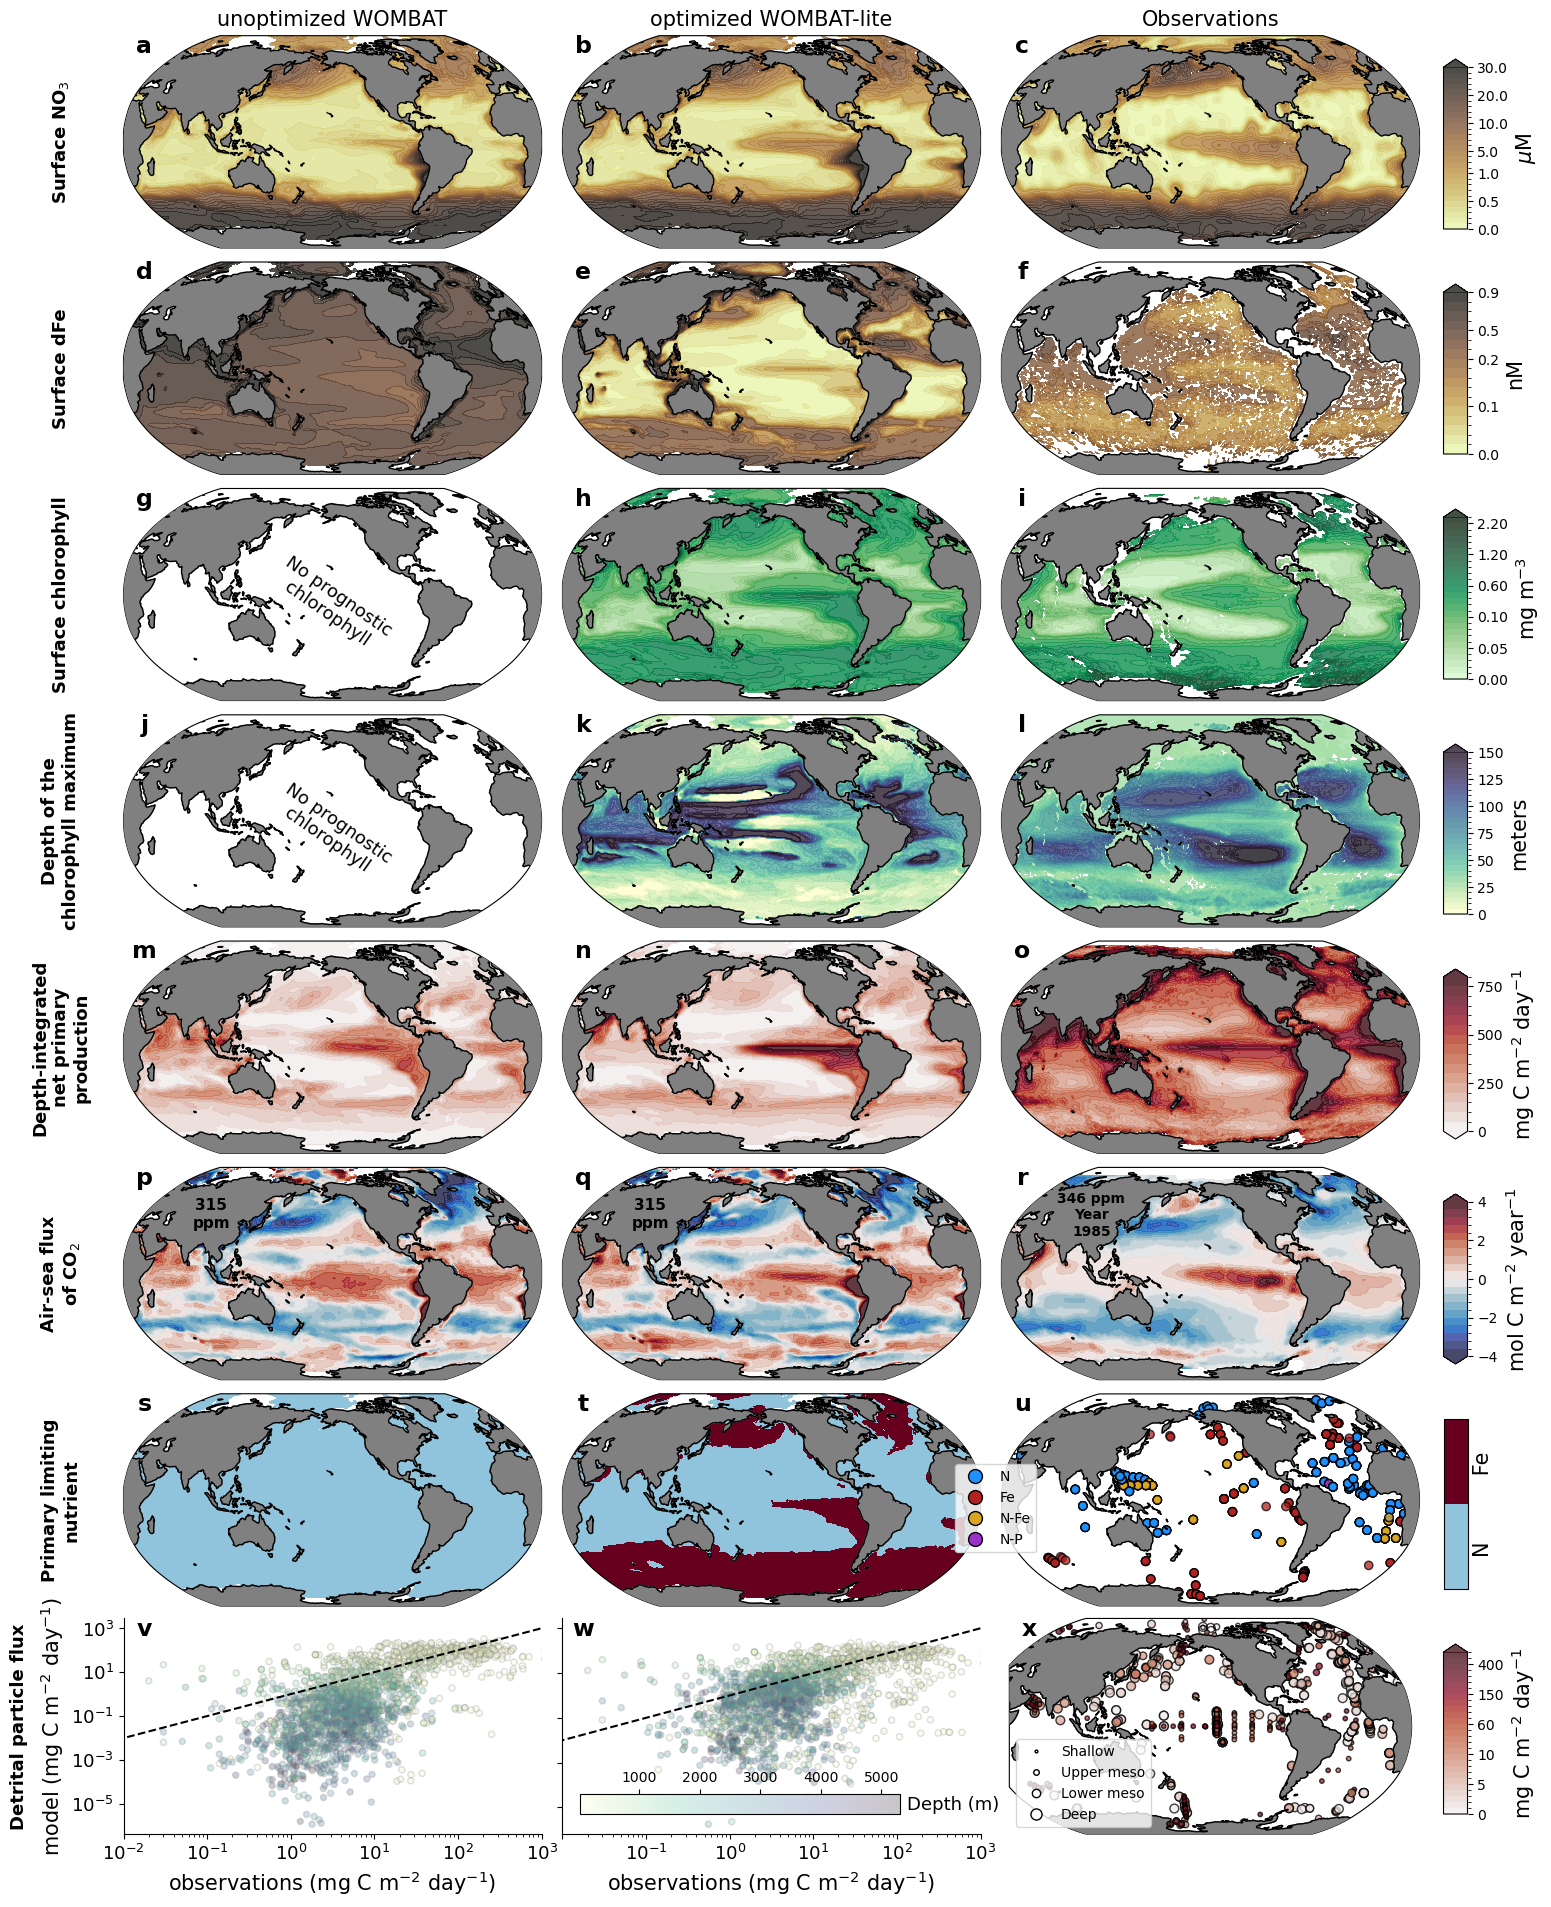

In [13]:
fslab = 15
fstic = 13

import matplotlib.lines as mlines
from cartopy.util import add_cyclic_point

proj = ccrs.Robinson(central_longitude=205)

colmap1 = lighten(cmo.turbid, 0.8)
colmap2 = lighten(cmo.turbid, 0.8)
colmap3 = lighten(cmo.algae, 0.8)
colmap4 = lighten(cmo.deep, 0.8)
colmap5 = lighten(cmo.amp, 0.8)
colmap6 = lighten(cmo.balance, 0.8)
colmap7 = {2.0:'dodgerblue', 3.0:'firebrick', 2.5:'goldenrod', 1.5:'darkorchid'}
colmap8 = lighten(cmo.amp, 0.8)

# surface NO3
levs1 = np.concatenate( (np.arange(0,1,0.1), np.arange(1,10,1), np.arange(10,30.1,2)) )
norm1 = mcolors.BoundaryNorm(levs1, ncolors=256)

# Surface dFe
levs2 = np.concatenate( (np.arange(0.0,0.2,0.02), np.arange(0.2,1,0.1)) )
norm2 = mcolors.BoundaryNorm(levs2, ncolors=256)

# Surface chlorophyll
levs3 = np.concatenate((np.arange(0.0,0.1,0.01), np.arange(0.1,1.0,0.1), np.arange(1.0, 2.5, 0.2) ))
norm3 = mcolors.BoundaryNorm(levs3, ncolors=256)

# Depth of max Chl
levs4 = np.arange(0,151,5)
norm4 = mcolors.BoundaryNorm(levs4, ncolors=256)

# Depth-integrated NPP (MODIS-based CbPM algorithm)
levs5 = np.arange(0,801,50)
norm5 = mcolors.BoundaryNorm(levs5, ncolors=256)

# Downward flux of CO2
levs6 = np.arange(-4,4.1,0.4)
norm6 = mcolors.BoundaryNorm(levs6, ncolors=256)

# Primary limiting nutrient
colors7 = [colmap7[lim] for lim in limitations['Primary']] 

# Downward flux of POC through ocean interior
levs8 = np.concatenate((np.arange(0,10,1), np.arange(10,100,10), np.arange(100,501,50)))
norm8 = mcolors.BoundaryNorm(levs8, ncolors=256)


fig = plt.figure(figsize=(16,20), facecolor='w')
gs = GridSpec(8, 3)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[0,2], projection=proj)
ax4 = plt.subplot(gs[1,0], projection=proj)
ax5 = plt.subplot(gs[1,1], projection=proj)
ax6 = plt.subplot(gs[1,2], projection=proj)
ax7 = plt.subplot(gs[2,0], projection=proj)
ax8 = plt.subplot(gs[2,1], projection=proj)
ax9 = plt.subplot(gs[2,2], projection=proj)
ax10 = plt.subplot(gs[3,0], projection=proj)
ax11 = plt.subplot(gs[3,1], projection=proj)
ax12 = plt.subplot(gs[3,2], projection=proj)
ax13 = plt.subplot(gs[4,0], projection=proj)
ax14 = plt.subplot(gs[4,1], projection=proj)
ax15 = plt.subplot(gs[4,2], projection=proj)
ax16 = plt.subplot(gs[5,0], projection=proj)
ax17 = plt.subplot(gs[5,1], projection=proj)
ax18 = plt.subplot(gs[5,2], projection=proj)
ax19 = plt.subplot(gs[6,0], projection=proj)
ax20 = plt.subplot(gs[6,1], projection=proj)
ax21 = plt.subplot(gs[6,2], projection=proj)
ax22 = plt.subplot(gs[7,0])
ax23 = plt.subplot(gs[7,1])
ax24 = plt.subplot(gs[7,2], projection=proj)

ax22.spines[['top','right']].set_visible(False)
ax23.spines[['top','right']].set_visible(False)
ax22.tick_params(labelsize=fstic)
ax23.tick_params(labelsize=fstic, labelleft=False)

p1 = ax1.contourf(lon_cyclic, lat_reg.isel(x=0), no3_old_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='max')
p2 = ax2.contourf(lon_cyclic, lat_reg.isel(x=0), no3_new_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='max')
p3 = ax3.contourf(lon_cyclic, lat_reg.isel(x=0), no3_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='max')

p4 = ax4.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_old_cyclic, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='max')
p5 = ax5.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_new_cyclic, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='max')
p6 = ax6.contourf(lon_dfecyc, lat_reg.isel(x=0), dfe_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='max')

#p7 = ax7.contourf(lon_cyclic, lat_reg.isel(x=0), chl_old_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')
p8 = ax8.contourf(lon_cyclic, lat_reg.isel(x=0), chl_new_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')
p9 = ax9.contourf(lon_dfecyc, lat_reg.isel(x=0), chl_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')

#p10 = ax10.contourf(lon_cyclic, lat_reg.isel(x=0), chz_old_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='max')
p11 = ax11.contourf(lon_cyclic, lat_reg.isel(x=0), chz_new_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='max')
p12 = ax12.contourf(lon_dfecyc, lat_reg.isel(x=0), chz_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='max')

p13 = ax13.contourf(lon_cyclic, lat_reg.isel(x=0), npp_old_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')
p14 = ax14.contourf(lon_cyclic, lat_reg.isel(x=0), npp_new_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')
p15 = ax15.contourf(lon_cyclic, lat_reg.isel(x=0), npp_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')

p16 = ax16.contourf(lon_cyclic, lat_reg.isel(x=0), -co2_old_cyclic, transform=ccrs.PlateCarree(), cmap=colmap6, norm=norm6, levels=levs6, extend='both')
p17 = ax17.contourf(lon_cyclic, lat_reg.isel(x=0), -co2_new_cyclic, transform=ccrs.PlateCarree(), cmap=colmap6, norm=norm6, levels=levs6, extend='both')
p18 = ax18.contourf(lon_cyclic, lat_reg.isel(x=0), -co2_obs_cyclic, transform=ccrs.PlateCarree(), cmap=colmap6, norm=norm6, levels=levs6, extend='both')

p19 = ax19.contourf(lon_cyclic, lat_reg.isel(x=0), lim_old_cyclic, transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.array([1.5,2.1,3.5]), extend='neither', vmax=2.5)
p20 = ax20.contourf(lon_cyclic, lat_reg.isel(x=0), lim_new_cyclic, transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.array([1.5,2.1,3.5]), extend='neither', vmax=2.5)

ax21.scatter(limitations['Lon'], limitations['Lat'], c=colors7, transform=ccrs.PlateCarree(), alpha=0.75, edgecolor='k')
points = [mlines.Line2D([], [], color=colmap7[2.0], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='N'),
          mlines.Line2D([], [], color=colmap7[3.0], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='Fe'),
          mlines.Line2D([], [], color=colmap7[2.5], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='N-Fe'),
          mlines.Line2D([], [], color=colmap7[1.5], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='N-P')]
ax21.legend(handles=points, bbox_to_anchor=(0.1,0.7))


p22 = ax22.scatter(pocflux_new['flux_mean'], oldpoc_flux, c=pocflux_new['Dep'], marker='o', cmap=cmo.deep, alpha=0.25, s=20, edgecolor='grey' )
p23 = ax23.scatter(pocflux_new['flux_mean'], newpoc_flux, c=pocflux_new['Dep'], marker='o', cmap=cmo.deep, alpha=0.25, s=20, edgecolor='grey' )

ax22.plot((1e-5,1e3),(1e-5,1e3), 'k--')
ax23.plot((1e-5,1e3),(1e-5,1e3), 'k--')

### make sizes of markers based on depth info
pocflux_cat = pd.cut(pocflux_dep.groupby('Location ID').mean(), bins=[0,150,500,1000,10000], labels=['Shallow', 'Upper mesopelagic', 'Lower mesopelagic', 'Deep'])
pocflux_siz = (pocflux_cat.cat.codes +1)*10
p24 = ax24.scatter(pocflux_lon.groupby('Location ID').mean(), pocflux_lat.groupby('Location ID').mean(), c=pocflux_ave.groupby('Location ID').mean(), 
                   s=pocflux_siz, transform=ccrs.PlateCarree(), alpha=0.75, edgecolor='k', cmap=colmap8, norm=norm8)
points = [mlines.Line2D([], [], color='w', marker='o', markeredgecolor='k', linestyle='None', markersize=pocflux_siz.sort_values().unique()[0]*0.2, label='Shallow'),
          mlines.Line2D([], [], color='w', marker='o', markeredgecolor='k', linestyle='None', markersize=pocflux_siz.sort_values().unique()[1]*0.2, label='Upper meso'),
          mlines.Line2D([], [], color='w', marker='o', markeredgecolor='k', linestyle='None', markersize=pocflux_siz.sort_values().unique()[2]*0.2, label='Lower meso'),
          mlines.Line2D([], [], color='w', marker='o', markeredgecolor='k', linestyle='None', markersize=pocflux_siz.sort_values().unique()[3]*0.2, label='Deep')]
ax24.legend(handles=points)


ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax2.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax3.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax3.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax4.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax4.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax9.add_feature(cfeature.LAND, color='grey', zorder=3)
ax9.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax12.add_feature(cfeature.LAND, color='grey', zorder=3)
ax12.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax13.add_feature(cfeature.LAND, color='grey', zorder=3)
ax13.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax14.add_feature(cfeature.LAND, color='grey', zorder=3)
ax14.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax15.add_feature(cfeature.LAND, color='grey', zorder=3)
ax15.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax16.add_feature(cfeature.LAND, color='grey', zorder=3)
ax16.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax17.add_feature(cfeature.LAND, color='grey', zorder=3)
ax17.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax18.add_feature(cfeature.LAND, color='grey', zorder=3)
ax18.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax19.add_feature(cfeature.LAND, color='grey', zorder=3)
ax19.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax20.add_feature(cfeature.LAND, color='grey', zorder=3)
ax20.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax21.add_feature(cfeature.LAND, color='grey', zorder=3)
ax21.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax24.add_feature(cfeature.LAND, color='grey', zorder=3)
ax24.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)

xx = -0.15; yy = 0.5
plt.text(xx,yy, 'Surface NO$_3$', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax1.transAxes)
plt.text(xx,yy, 'Surface dFe', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax4.transAxes)
plt.text(xx,yy, 'Surface chlorophyll', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax7.transAxes)
plt.text(xx,yy, 'Depth of the\nchlorophyll maximum', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax10.transAxes)
plt.text(xx,yy, 'Depth-integrated\nnet primary\nproduction', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax13.transAxes)
plt.text(xx,yy, 'Air-sea flux\nof CO$_2$', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax16.transAxes)
plt.text(xx,yy, 'Primary limiting\nnutrient', ha='center', va='center', fontweight='bold', rotation=90, fontsize=fstic, transform=ax19.transAxes)
plt.text(xx-0.1,yy, 'Detrital particle flux', ha='center', va='center', fontweight='bold', rotation=90, fontsize=fstic, transform=ax22.transAxes)

plt.text(0.5, 1.075, 'unoptimized WOMBAT', va='center', ha='center', fontsize=fslab, transform=ax1.transAxes)
plt.text(0.5, 1.075, 'optimized WOMBAT-lite', va='center', ha='center', fontsize=fslab, transform=ax2.transAxes)
plt.text(0.5, 1.075, 'Observations', va='center', ha='center', fontsize=fslab, transform=ax3.transAxes)

plt.subplots_adjust(left=0.075, bottom=0.05, top=0.95, right=0.885, hspace=0.05, wspace=0.05)

cbax1 = fig.add_axes([0.9, 0.8525, 0.015, 0.085])
cbax2 = fig.add_axes([0.9, 0.7400, 0.015, 0.085])
cbax3 = fig.add_axes([0.9, 0.6275, 0.015, 0.085])
cbax4 = fig.add_axes([0.9, 0.5100, 0.015, 0.085])
cbax5 = fig.add_axes([0.9, 0.3975, 0.015, 0.085])
cbax6 = fig.add_axes([0.9, 0.2850, 0.015, 0.085])
cbax7 = fig.add_axes([0.9, 0.1725, 0.015, 0.085])
cbax8 = fig.add_axes([0.9, 0.0600, 0.015, 0.085])
cbax8a = fig.add_axes([0.36, 0.06, 0.2, 0.01])

cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[[0,5,10,14,19,24,-1]])
cbar2 = plt.colorbar(p4, cax=cbax2, orientation='vertical', ticks=levs2[[0,5,10,13,-1]])
cbar3 = plt.colorbar(p8, cax=cbax3, orientation='vertical', ticks=levs3[::5])
cbar4 = plt.colorbar(p11, cax=cbax4, orientation='vertical', ticks=levs4[::5])
cbar5 = plt.colorbar(p13, cax=cbax5, orientation='vertical', ticks=levs5[::5])
cbar6 = plt.colorbar(p16, cax=cbax6, orientation='vertical', ticks=levs6[::5])
cbar7 = plt.colorbar(p19, cax=cbax7, orientation='vertical', ticks=[2.0,3.0])
cbar8 = plt.colorbar(p24, cax=cbax8, orientation='vertical', ticks=levs8[::5], extend='max')
cbar8a = plt.colorbar(p22, cax=cbax8a, orientation='horizontal')

cbar7.ax.tick_params(labelright=False, right=False)
cbar8a.ax.tick_params(labelbottom=False, bottom=False, labeltop=True, top=True)

cbar1.ax.set_ylabel('$\mu$M', fontsize=fslab)
cbar2.ax.set_ylabel('nM', fontsize=fslab)
cbar3.ax.set_ylabel('mg m$^{-3}$', fontsize=fslab)
cbar4.ax.set_ylabel('meters', fontsize=fslab)
cbar5.ax.set_ylabel('mg C m$^{-2}$ day$^{-1}$', fontsize=fslab)
cbar6.ax.set_ylabel('mol C m$^{-2}$ year$^{-1}$', fontsize=fslab)
cbar7.ax.set_ylabel('N          Fe', fontsize=fslab)
cbar8.ax.set_ylabel('mg C m$^{-2}$ day$^{-1}$', fontsize=fslab)
#cbar8a.ax.set_xlabel('Depth (m)', fontsize=fslab)
#cbar8a.ax.xaxis.set_label_position('right')

plt.text(0.825,0.135, 'Depth (m)', fontsize=fstic, ha='left', va='center', transform=ax23.transAxes)

plt.text(0.5,0.45, 'No prognostic\nchlorophyll', fontsize=fstic, ha='center', va='center', transform=ax7.transAxes, rotation=-35)
plt.text(0.5,0.45, 'No prognostic\nchlorophyll', fontsize=fstic, ha='center', va='center', transform=ax10.transAxes, rotation=-35)
plt.text(0.21,0.78, '315\nppm', fontsize=fstic-2, ha='center', va='center', fontweight='bold', transform=ax16.transAxes)
plt.text(0.21,0.78, '315\nppm', fontsize=fstic-2, ha='center', va='center', fontweight='bold', transform=ax17.transAxes)
plt.text(0.215,0.775, '346 ppm\nYear\n1985', fontsize=fstic-3, ha='center', va='center', fontweight='bold', transform=ax18.transAxes)

xx = 0.05
yy = 0.95
plt.text(xx,yy, 'a', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax1.transAxes)
plt.text(xx,yy, 'b', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax2.transAxes)
plt.text(xx,yy, 'c', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax3.transAxes)
plt.text(xx,yy, 'd', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax4.transAxes)
plt.text(xx,yy, 'e', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax5.transAxes)
plt.text(xx,yy, 'f', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax6.transAxes)
plt.text(xx,yy, 'g', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax7.transAxes)
plt.text(xx,yy, 'h', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax8.transAxes)
plt.text(xx,yy, 'i', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax9.transAxes)
plt.text(xx,yy, 'j', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax10.transAxes)
plt.text(xx,yy, 'k', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax11.transAxes)
plt.text(xx,yy, 'l', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax12.transAxes)
plt.text(xx,yy, 'm', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax13.transAxes)
plt.text(xx,yy, 'n', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax14.transAxes)
plt.text(xx,yy, 'o', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax15.transAxes)
plt.text(xx,yy, 'p', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax16.transAxes)
plt.text(xx,yy, 'q', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax17.transAxes)
plt.text(xx,yy, 'r', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax18.transAxes)
plt.text(xx,yy, 's', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax19.transAxes)
plt.text(xx,yy, 't', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax20.transAxes)
plt.text(xx,yy, 'u', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax21.transAxes)
plt.text(xx,yy, 'v', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax22.transAxes)
plt.text(xx,yy, 'w', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax23.transAxes)
plt.text(xx,yy, 'x', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax24.transAxes)

ax22.set_xscale('log'); ax22.set_yscale('log'); ax22.set_xlim(1e-2,1e3); ax22.set_ylabel('model (mg C m$^{-2}$ day$^{-1}$)', fontsize=fslab); ax22.set_xlabel('observations (mg C m$^{-2}$ day$^{-1}$)', fontsize=fslab)
ax23.set_xscale('log'); ax23.set_yscale('log'); ax23.set_xlim(1e-2,1e3); ax23.set_xlabel('observations (mg C m$^{-2}$ day$^{-1}$)', fontsize=fslab)
ax23.set_xticks([1e-2,1e-1,1e0,1e1,1e2,1e3], [' ', '10$^{-1}$', '10$^{0}$', '10$^{1}$', '10$^{2}$', '10$^{3}$'])

os.chdir(wrkdir)
fig.savefig("figures/section3.4-sidebyside.png", dpi=300)
fig.savefig("figures/section3.4-sidebyside.pdf", dpi=300)
fig.savefig("figures/section3.4-sidebyside_transparent.png", dpi=300, transparent=True)
